In [39]:
import numpy as np
from scipy.sparse.csgraph import connected_components
import networkx as nx

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm.notebook import tqdm
from IPython.display import clear_output

In [3]:
def power_law(a, b, g, size):
    """ Power-law gen for pdf(x) prop to x^{g} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**(g+1), b**(g+1)

    return (ag + (bg - ag)*r)**(1./(g+1))

In [160]:
results_folder = 'results/'
delimiter = '_'

class HTC:
    
    def __init__(self, W = None,
                 network='connectome', weights='power_law',
                 N=66, **kwargs):
        '''
        Class initializer
        '''
        
        self.W = W
        self.network = network
        self.N = N
        self.weights = weights
        
        self.Tmin = 0.2
        self.Tmax = 1.5
        self.dT = 0.05
        
        # Unpack parameters
        self.unpack_parameters(**kwargs)
        
        # Initialize empty containers
        self.A, self.sigmaA, self.S1, self.S2, self.pdf = [None for _ in range(5)]
        self.A_norm, self.sigmaA_norm, self.S1_norm, self.S2_norm, self.pdf_norm = [None for _ in range(5)] 
        
        # Create network topology and compute parameters
        self.generate_network()
        self.compute_parameters()
        
     
    @classmethod
    def loadFromName(cls, name):
        network = name.split(delimiter)[0]
        
        # Load weights matrix
        W = np.loadtxt(results_folder+name+delimiter+'matrix.txt')
        
        # Generate HTC object
        if network == 'random':
            network, N, p = name.split(delimiter)
            N, p = int(N), float(p)
            tmp = cls(W=W, N=N, network=network, p=p)
        elif network == 'small':
            network, N, k, p = name.split(delimiter)
            N, k, p = int(N), int(k), float(p)
            tmp = cls(W=W, N=N, network=network, k=k, p=p)
        elif network == 'barabasi':
            network, N, k = name.split(delimiter)
            N, k = int(N), int(k)
            tmp = cls(W=W, N=N, network=network, k=k)
        elif network == 'powerlaw':
            network, N, k, p = name.split(delimiter)
            N, k, p = int(N), int(k), float(p)
            tmp = cls(W=W, N=N, network=network, k=k, p=p)
        elif network == 'complete':
            network, N = name
            N = int(N)
            tmp = cls(W=W, N=N, network=network)
        
        # Load activity and (if present) cluster size
        act = np.loadtxt(results_folder+name+delimiter+str('activity.txt'))
        
        if len(act)==8:
            tmp.A, tmp.sigmaA, tmp.A_norm, tmp.sigmaA_norm, tmp.S1, tmp.S2, tmp.S1_norm, tmp.S2_norm = act
            tmp.pdf, tmp.pdf_norm = np.loadtxt(results_folder+name+delimiter+str('pdf.txt')).T
        else:
            tmp.A, tmp.sigmaA, tmp.A_norm, tmp.sigmaA_norm = act
        
        return tmp
    
    
    def unpack_parameters(self, **kwargs):
        '''
        Unpack parameters and create name/title
        '''
        
        self.title = 'Network=' + self.network + ', N=' + str(self.N)
        self.name = self.network + delimiter + str(self.N)
    
        if self.network == 'random':
            if not 'p' in kwargs.keys():
                raise Exception('Random network generator needs p')
            self.p = kwargs['p']
            self.title += ', p=' + str(self.p)
            self.name += delimiter + str(self.p)
            
        elif self.network == 'small':
            if not ('k' and 'p') in kwargs.keys():
                raise Exception('Small world generator needs k and p')
            self.k = kwargs['k']
            self.p = kwargs['p']
            self.title += ', k=' + str(self.k) + ', p=' + str(self.p)
            self.name += delimiter + str(self.k) + delimiter + str(self.p)
            
        elif self.network == 'barabasi':
            if not 'k' in kwargs.keys():
                raise Exception('Barabasi generator needs k')
            self.k = kwargs['k']
            self.title += ', k=' + str(self.k)
            self.name += delimiter + str(self.k)
            
        elif self.network == 'powerlaw':
            if not ('k' and 'p') in kwargs.keys():
                raise Exception('Powerlaw network generator needs k and p')
            self.k = kwargs['k']
            self.p = kwargs['p']
            self.title += ', k=' + str(self.k) + ', p=' + str(self.p)
            self.name += delimiter + str(self.k) + delimiter + str(self.p)
            
    
    def generate_network(self):
        '''
        Generate network topology
        '''
        
        # Check if network read from .txt
        if not self.W is None:
            # Create normalized matrix
            self.W_norm = self.W / np.sum(self.W, axis=0)[:,None]
            return
        
        # Generate adjacency matrix
        if self.network == 'connectome':
            self.W = np.loadtxt('dati/RSN/RSN_matrix.txt')
        else:
            if self.network == 'random':
                top = nx.erdos_renyi_graph(self.N, self.p)
            elif self.network == 'small':
                top = nx.watts_strogatz_graph(self.N, self.k, self.p)
            elif self.network == 'barabasi':
                top = nx.barabasi_albert_graph(self.N, self.k)
            elif self.network == 'powerlaw':
                top = nx.powerlaw_cluster_graph(self.N, self.k, self.p)
            elif self.network == 'complete':
                top = nx.complete_graph(self.N)
                
            top = nx.adjacency_matrix(top).toarray()
            
            # Generate weights from distribution
            if self.weights == 'unif':
                self.W = np.random.uniform(0., .5, size=(self.N, self.N))
            elif self.weights == 'power_law':
                self.W = power_law(5*10**-3, .5, g=-1.5, size=(self.N, self.N))
            else:
                raise Exception('Distribution not defined')
            
            # Symmetrize and mask with topology
            self.W = np.triu(self.W, 1)
            self.W = self.W + self.W.T
            self.W = self.W * top
        
        # Create normalized matrix
        self.W_norm = self.W / np.sum(self.W, axis=0)[:,None]
        # TODO: the sum of a single row can be zero, so pay attention
        
    
    def compute_parameters(self):
        '''
        Compute transition rates and (theorical) critical temperature
        '''
        
        self.r1 = 2./self.N
        self.r2 = self.r1**(1./5.)
        self.Tc = self.r2 / (1. + 2.*self.r2)
        self.Trange = np.arange(self.Tmin, self.Tmax+self.dT, self.dT) * self.Tc
    
    
    def simulate(self, cluster=False, steps=6000, runs=50, dt=0.1, N_cluster=1000):
        '''
        Run simulation for both original and normalized matrices
        '''
        
        self.cluster = cluster
        
        if cluster:
            self.A, self.sigmaA, self.S1, self.S2, self.pdf = self.run_model(self.W, cluster, steps, runs, dt, N_cluster)
            self.A_norm, self.sigmaA_norm, self.S1_norm, self.S2_norm, self.pdf_norm = self.run_model(self.W_norm, cluster, steps, runs, dt, N_cluster)
        else:
            self.A, self.sigmaA = self.run_model(self.W, cluster, steps, runs, dt, N_cluster)
            self.A_norm, self.sigmaA_norm = self.run_model(self.W_norm, cluster, steps, runs, dt, N_cluster)
            
    
    def run_model(self, W, cluster, steps, runs, dt, N_cluster):
        '''
        HTC model
        '''
        
        dt_cluster = int(steps/N_cluster)
        
        # treshold interval
        W_mean = np.mean(np.sum(W, axis=0))
        Trange = self.Trange * W_mean
        
        # define empty matrix to store results
        A, sigma_A = [np.zeros(len(Trange)) for _ in range(2)]
        if cluster:
            S1, S2 = [np.zeros(len(Trange)) for _ in range(2)]
            pdf = [Counter() for _ in range(len(Trange))]
            
        # LOOP OVER TEMPERATUREs
        for i,T in enumerate(Trange):
            clear_output(wait=True)
            print(self.title + '\n')
            print(str(i+1) + '/'+ str(len(Trange)) + ': HTC with T = ' +  str(round(T/self.Tc/W_mean, 2)) + ' * Tc' )

            # initial configurations -> random I and R states
            S = np.random.randint(-1, 1, size=(runs,self.N))
            s = (S==1).astype(int)

            # create empty array to store activity and cluster size over time
            At = np.zeros((runs, steps))

            if cluster:
                S1t = np.zeros((runs, N_cluster))
                S2t = np.zeros((runs, N_cluster))

            # LOOP OVER TIME STEPS
            for t in tqdm(range(steps)):
                probs = np.random.rand(runs, self.N)    # generate probabilities

                pA = self.r1 + (1.-self.r1) * ( (W@s.T)>T )  # prob. to become active

                # UPDATE STATE VECTOR
                S = ( (S==0)*(probs<pA.T)          # I->A
                     + (S==1)*-1                   # A->R
                     + (S==-1)*(probs>self.r2)*-1 )     # R->I (remain R with prob 1-r2)

                s = (S==1).astype(int)

                At[:,t] = np.mean(s, axis=1)       # compute activity

                # COMPUTE CLUSTERS
                if cluster and (not t%dt_cluster):
                    tempT = t//dt_cluster
                    for j in range(runs):
                        S1t[j,tempT], S2t[j,tempT], tmp_counts = self.compute_clusters(W, s[j])
                        pdf[i] += tmp_counts
            # END LOOP OVER TIME

            # COMPUTE AVERAGES
            A[i] = np.mean(At)
            sigma_A[i] = np.mean( np.std(At, axis=1) )
            if cluster:
                S1[i] = np.mean(S1t)
                S2[i] = np.mean(S2t)

        # RETURN RESULTS
        if cluster:
            return (A, sigma_A, S1/W.shape[0], S2/W.shape[0], pdf)
        else:
            return (A, sigma_A)
     
    
    def compute_clusters(self, W, sj):
        '''
        Compute cluster analysis
        '''
        
        # mask adjacency matrix with active nodes
        mask = W * sj
        mask = mask.T * sj
        # compute connected components
        _, labels = connected_components(mask, directed=False)
        # count labels occurrence
        _, counts = np.unique(labels, return_counts=True)
        counts = -np.sort(-counts)
        
        # return (biggest cluster, second biggest cluster, clusters occurrence)
        return (counts[0], counts[1], Counter(counts))
       
        
    def plot_activity(self):
        fig, ax1 = plt.subplots(figsize=(12,6))
        plt.grid()

        ax1.plot(self.Trange/self.Tc, self.A, label=r'$A$', c='black')
        ax1.scatter(self.Trange/self.Tc, self.A, c='black')
        ax1.plot(self.Trange/self.Tc, self.A_norm, label=r'$A_{norm}$', c='red')
        ax1.scatter(self.Trange/self.Tc, self.A_norm, c='red')
        ax1.set_xlabel(r'$T/T_c$', size=12)
        ax1.set_ylabel(r'$<A>$', size=12)

        ax2 = ax1.twinx()
        ax2.plot(self.Trange/self.Tc, self.sigmaA, '-.', label=r'$\sigma_A$', c='black')
        ax2.plot(self.Trange/self.Tc, self.sigmaA_norm, '-.', label=r'$\sigma_{A,norm}$', c='red')
        ax2.set_ylabel(r'$\sigma(A)$', size=12)

        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        plt.legend(h1+h2, l1+l2, fontsize=12)
        plt.title(self.title, size=13)

        fig.tight_layout()
        plt.show()
        
        
    def plot_cluster(self):
        fig, ax1 = plt.subplots(figsize=(12,6))
        plt.grid()

        ax1.plot(self.Trange/self.Tc, self.S1, label=r'$S1$', c='black')
        ax1.plot(self.Trange/Tc, self.S1_norm, label=r'$S1_{norm}$', c='red')
        ax1.set_xlabel(r'$T/T_c$', fontsize=12)
        ax1.set_ylabel(r'$<S1>/N$', fontsize=12)

        ax2 = ax1.twinx()
        ax2.plot(self.Trange/self.Tc, self.S2, '-.', label=r'$S2$', c='black')
        ax2.plot(self.Trange/self.Tc, self.S2_norm, '-.', label=r'$S2_{norm}$', c='red')
        ax2.set_ylabel(r'$<S2>/N$', fontsize=12)

        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        plt.legend(h1+h2, l1+l2, fontsize=12)

        fig.tight_layout()
        plt.show()
    
    
    def draw_network(self):
        G = nx.from_numpy_matrix(self.W)
        pos = nx.spring_layout(G)  # positions for all nodes
        
        fig, _ = plt.subplots(figsize=(12,6))

        nx.draw_networkx_nodes(G, pos, node_color="r", node_size=300)
        for edge in G.edges(data='weight'):
            #nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2]*20)
            nx.draw_networkx_edges(G, pos, edgelist=[edge])
            
        plt.axis('off')
        plt.show()

    
    def save(self):
        '''
        Save output
        '''
        
        filename = results_folder+self.name
        
        # Save weights matrix
        np.savetxt(filename + '_matrix.txt', self.W)
        
        if not self.cluster:
            np.savetxt(filename + '_activity.txt',
                       (self.A,self.sigmaA,self.A_norm,self.sigmaA_norm), fmt='%e')
        else:
            np.savetxt(filename + '_activity.txt',
                       (self.A,self.sigmaA,self.A_norm,self.sigmaA_norm,
                       self.S1, self.S2, self.S1_norm, self.S2_norm), fmt='%e')
        
            with open(filename + '_pdf.txt', 'w') as outfile:
                for x in self.pdf:
                    np.savetxt(outfile, np.asarray(x.most_common()))
                    outfile.write('\n')
                for x in self.pdf_norm:
                    np.savetxt(outfile, np.asarray(x.most_common()))
                    outfile.write('\n')

# Random graph with different p

In [164]:
ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

models_random = []

for p in ps:
    models_random.append( HTC(network='random', p=p) )

In [165]:
for model in models_random:
    model.simulate(cluster=True)
    model.save()

Network=random, N=66, p=0.6

27/27: HTC with T = 1.5 * Tc


# Small world with different k

In [166]:
ks = [5, 10, 15, 20, 30, 40]

In [167]:
models_small = []

for k in ks:
    models_small.append( HTC(network='small', k=k, p=0.5) )

In [168]:
for model in models_small:
    model.simulate(cluster=True)
    model.save()

Network=small, N=66, k=40, p=0.5

27/27: HTC with T = 1.5 * Tc


# Barabasi with different m

In [169]:
ms = [5, 10, 15, 20, 30, 40]

In [170]:
models_bar = []

for k in ms:
    models_bar.append( HTC(network='barabasi', k=k) )

In [171]:
for model in models_bar:
    model.simulate(cluster=True)
    model.save()

Network=barabasi, N=66, k=40

27/27: HTC with T = 1.5 * Tc


# Plots

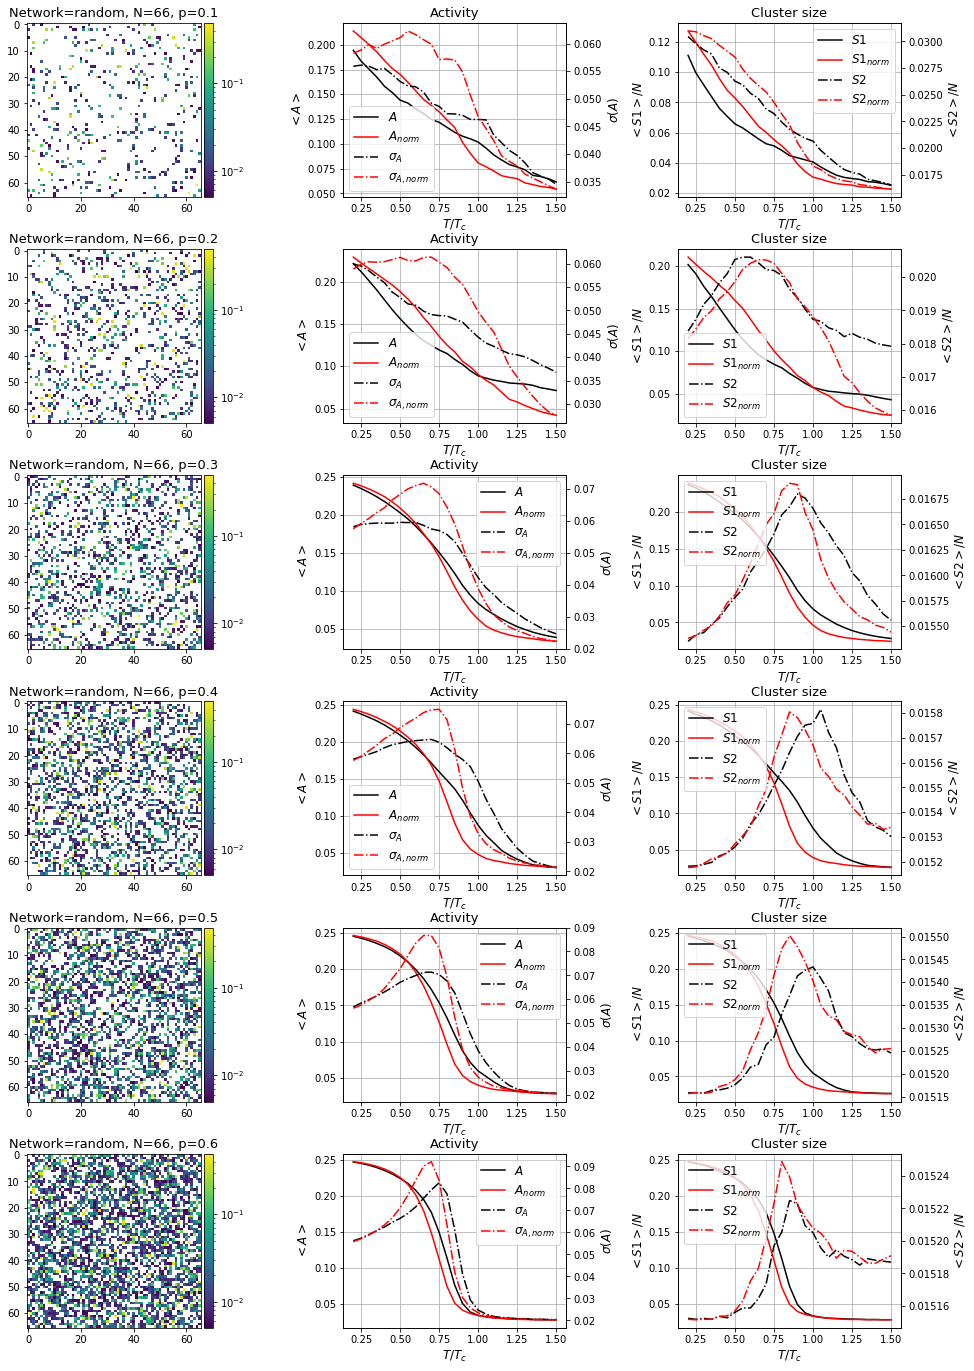

In [173]:
plt.figure(figsize=(16,24))

for i, model in enumerate(models_random):
    # Plot network
    ax = plt.subplot(len(models_random), 3, 3*i+1)
    
    im = ax.imshow(model.W, norm=matplotlib.colors.LogNorm())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    ax.set_title(model.title, size=13)
    #plt.show()
    
    # Plot activity
    ax1 = plt.subplot(len(models_random), 3, 3*i+2)
    
    plt.grid()

    ax1.plot(model.Trange/model.Tc, model.A, label=r'$A$', c='black')
    #ax1.scatter(model.Trange/model.Tc, model.A, c='black')
    ax1.plot(model.Trange/model.Tc, model.A_norm, label=r'$A_{norm}$', c='red')
    #ax1.scatter(model.Trange/model.Tc, model.A_norm, c='red')
    ax1.set_xlabel(r'$T/T_c$', size=12)
    ax1.set_ylabel(r'$<A>$', size=12)

    ax2 = ax1.twinx()
    ax2.plot(model.Trange/model.Tc, model.sigmaA, '-.', label=r'$\sigma_A$', c='black')
    ax2.plot(model.Trange/model.Tc, model.sigmaA_norm, '-.', label=r'$\sigma_{A,norm}$', c='red')
    ax2.set_ylabel(r'$\sigma(A)$', size=12)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=12)
    plt.title('Activity', size=13)
    
    # Plot cluster
    ax1 = plt.subplot(len(models_random), 3, 3*i+3)
    plt.grid()

    ax1.plot(model.Trange/model.Tc, model.S1, label=r'$S1$', c='black')
    ax1.plot(model.Trange/model.Tc, model.S1_norm, label=r'$S1_{norm}$', c='red')
    ax1.set_xlabel(r'$T/T_c$', fontsize=12)
    ax1.set_ylabel(r'$<S1>/N$', fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(model.Trange/model.Tc, model.S2, '-.', label=r'$S2$', c='black')
    ax2.plot(model.Trange/model.Tc, model.S2_norm, '-.', label=r'$S2_{norm}$', c='red')
    ax2.set_ylabel(r'$<S2>/N$', fontsize=12)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=12)
    plt.title('Cluster size', size=13)

#fig.tight_layout()
plt.subplots_adjust(hspace = 0.3, wspace = 0.5)
plt.show()

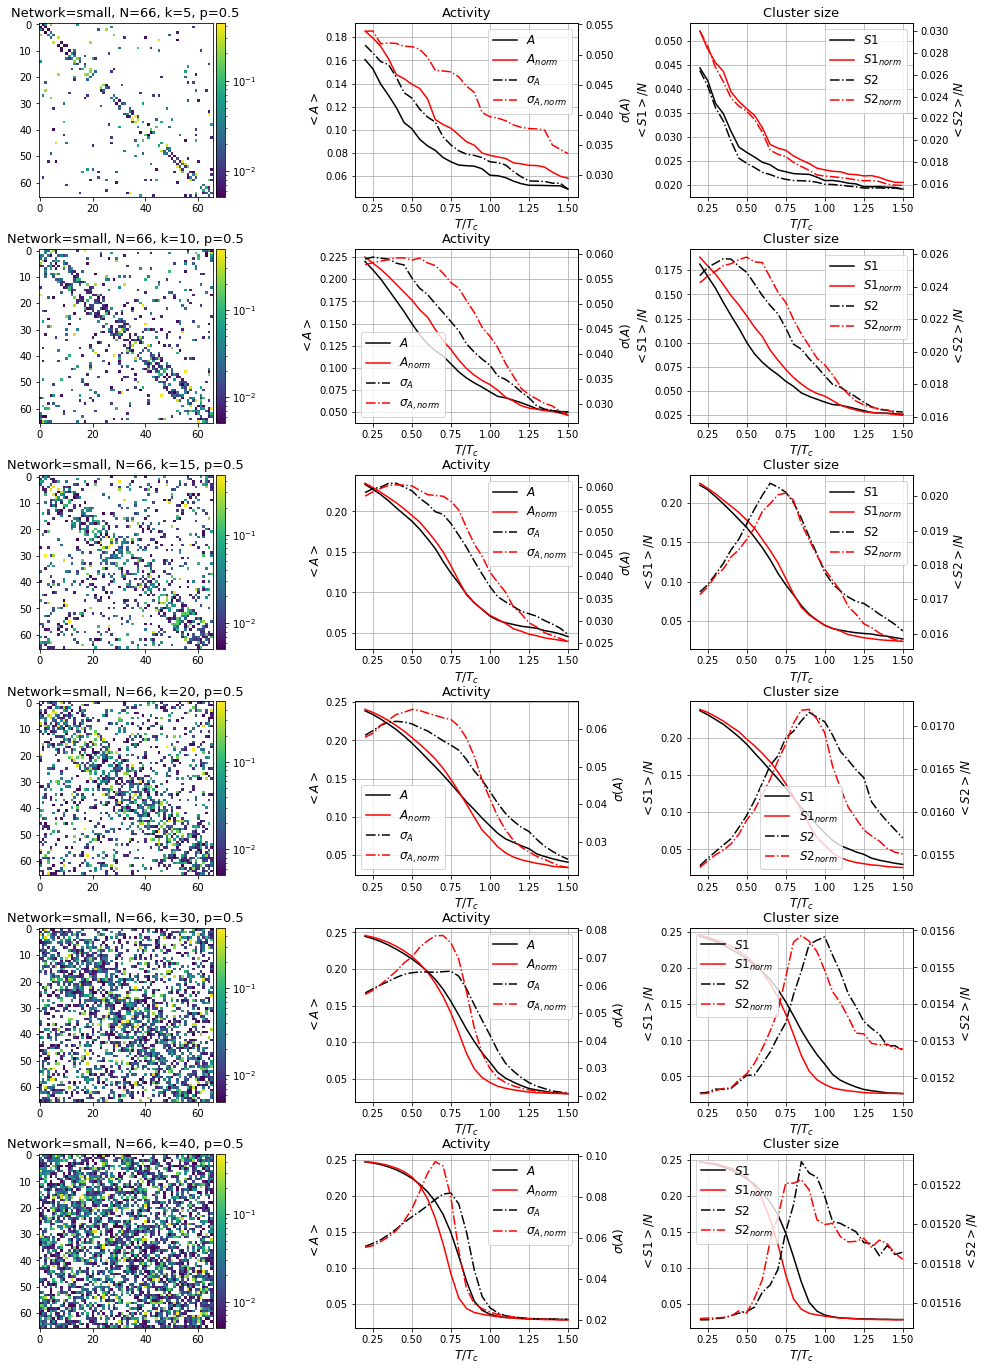

In [175]:
plt.figure(figsize=(16,24))

for i, model in enumerate(models_small):
    # Plot network
    ax = plt.subplot(len(models_small), 3, 3*i+1)
    
    im = ax.imshow(model.W, norm=matplotlib.colors.LogNorm())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    ax.set_title(model.title, size=13)
    #plt.show()
    
    # Plot activity
    ax1 = plt.subplot(len(models_small), 3, 3*i+2)
    
    plt.grid()

    ax1.plot(model.Trange/model.Tc, model.A, label=r'$A$', c='black')
    #ax1.scatter(model.Trange/model.Tc, model.A, c='black')
    ax1.plot(model.Trange/model.Tc, model.A_norm, label=r'$A_{norm}$', c='red')
    #ax1.scatter(model.Trange/model.Tc, model.A_norm, c='red')
    ax1.set_xlabel(r'$T/T_c$', size=12)
    ax1.set_ylabel(r'$<A>$', size=12)

    ax2 = ax1.twinx()
    ax2.plot(model.Trange/model.Tc, model.sigmaA, '-.', label=r'$\sigma_A$', c='black')
    ax2.plot(model.Trange/model.Tc, model.sigmaA_norm, '-.', label=r'$\sigma_{A,norm}$', c='red')
    ax2.set_ylabel(r'$\sigma(A)$', size=12)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=12)
    plt.title('Activity', size=13)
    
    # Plot cluster
    ax1 = plt.subplot(len(models_small), 3, 3*i+3)
    plt.grid()

    ax1.plot(model.Trange/model.Tc, model.S1, label=r'$S1$', c='black')
    ax1.plot(model.Trange/model.Tc, model.S1_norm, label=r'$S1_{norm}$', c='red')
    ax1.set_xlabel(r'$T/T_c$', fontsize=12)
    ax1.set_ylabel(r'$<S1>/N$', fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(model.Trange/model.Tc, model.S2, '-.', label=r'$S2$', c='black')
    ax2.plot(model.Trange/model.Tc, model.S2_norm, '-.', label=r'$S2_{norm}$', c='red')
    ax2.set_ylabel(r'$<S2>/N$', fontsize=12)
    #ax2.set_ylim([min(model.S2)-0.001, max(model.S2)+0.001])

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=12)
    plt.title('Cluster size', size=13)

#fig.tight_layout()
plt.subplots_adjust(hspace = 0.3, wspace = 0.5)
plt.show()

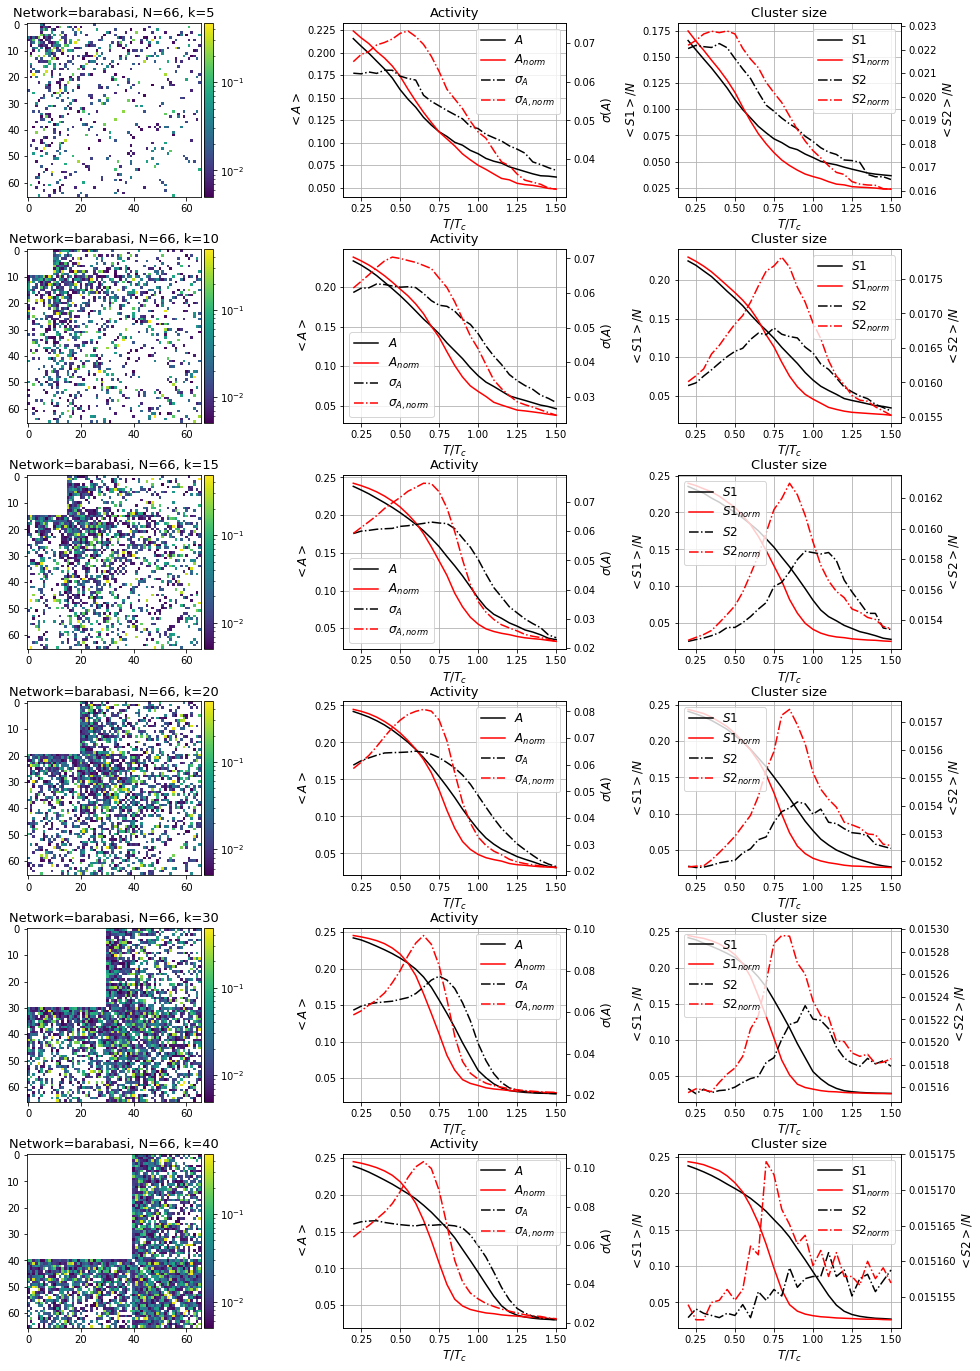

In [176]:
plt.figure(figsize=(16,24))

for i, model in enumerate(models_bar):
    # Plot network
    ax = plt.subplot(len(models_bar), 3, 3*i+1)
    
    im = ax.imshow(model.W, norm=matplotlib.colors.LogNorm())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    ax.set_title(model.title, size=13)
    #plt.show()
    
    # Plot activity
    ax1 = plt.subplot(len(models_bar), 3, 3*i+2)
    
    plt.grid()

    ax1.plot(model.Trange/model.Tc, model.A, label=r'$A$', c='black')
    #ax1.scatter(model.Trange/model.Tc, model.A, c='black')
    ax1.plot(model.Trange/model.Tc, model.A_norm, label=r'$A_{norm}$', c='red')
    #ax1.scatter(model.Trange/model.Tc, model.A_norm, c='red')
    ax1.set_xlabel(r'$T/T_c$', size=12)
    ax1.set_ylabel(r'$<A>$', size=12)

    ax2 = ax1.twinx()
    ax2.plot(model.Trange/model.Tc, model.sigmaA, '-.', label=r'$\sigma_A$', c='black')
    ax2.plot(model.Trange/model.Tc, model.sigmaA_norm, '-.', label=r'$\sigma_{A,norm}$', c='red')
    ax2.set_ylabel(r'$\sigma(A)$', size=12)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=12)
    plt.title('Activity', size=13)
    
    # Plot cluster
    ax1 = plt.subplot(len(models_bar), 3, 3*i+3)
    plt.grid()

    ax1.plot(model.Trange/model.Tc, model.S1, label=r'$S1$', c='black')
    ax1.plot(model.Trange/model.Tc, model.S1_norm, label=r'$S1_{norm}$', c='red')
    ax1.set_xlabel(r'$T/T_c$', fontsize=12)
    ax1.set_ylabel(r'$<S1>/N$', fontsize=12)

    ax2 = ax1.twinx()
    ax2.plot(model.Trange/model.Tc, model.S2, '-.', label=r'$S2$', c='black')
    ax2.plot(model.Trange/model.Tc, model.S2_norm, '-.', label=r'$S2_{norm}$', c='red')
    ax2.set_ylabel(r'$<S2>/N$', fontsize=12)
    #ax2.set_ylim([min(model.S2)-0.001, max(model.S2)+0.001])

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, fontsize=12)
    plt.title('Cluster size', size=13)

#fig.tight_layout()
plt.subplots_adjust(hspace = 0.3, wspace = 0.5)
plt.show()